<a href="https://colab.research.google.com/github/karanpreetkaur/instacart_market_basket_analysis/blob/main/Instacart_market_basket_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%%capture
!sudo apt-get update --fix-missing

!apt-get install openjdk-8-jdk-headless -qq > /dev/null

!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz
#!wget -q https://downloads.apache.org/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

!mv spark-3.0.0-bin-hadoop3.2.tgz sparkkk
!tar xf sparkkk
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName('fpgrowth') \
    .getOrCreate()

spark   

### Imports

In [ ]:
from pyspark.sql.functions import when
from pyspark.sql.functions import collect_set, col, count
from pyspark.sql.functions import size

from pyspark.ml.fpm import FPGrowth

import altair as alt
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [23]:
alt.data_transformers.disable_max_rows()
alt.renderers.enable('colab')

RendererRegistry.enable('colab')

## Market Basket Analysis using Instacart Online Grocery Dataset

Which products will an Instacart consumer purchase again?

In [ ]:
# Import data in spark dataframes
aisles = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/aisles.csv/aisles.csv", header=True)
departments = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/departments.csv/departments.csv", header=True)
order_products_prior = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/order_products__prior.csv/order_products__prior.csv", header=True)
order_products_train = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/order_products__train.csv/order_products__train.csv", header=True)
orders = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/orders.csv/orders.csv", header=True)
products = spark.read.csv("/content/gdrive/MyDrive/Market_Basket_Analysis/instacart-market-basket-analysis/products.csv/products.csv", header=True)

# Exploratory Data Analysis



### Find busiest day of week

In [ ]:
orders = orders.withColumn("order_dow", when(orders['order_dow'] == 0, 'Sunday')
                                        .when(orders['order_dow'] == 1, 'Monday')
                                        .when(orders['order_dow'] == 2, 'Tuesday')
                                        .when(orders['order_dow'] == 3, 'Wednesday')
                                        .when(orders['order_dow'] == 4, 'Thursday')
                                        .when(orders['order_dow'] == 5, 'Friday')
                                        .when(orders['order_dow'] == 6, 'Saturday'))

In [ ]:
orders_dow_count = orders.groupBy('order_dow').count()

In [ ]:
orders_dow_count = orders_dow_count.toPandas()

In [24]:
alt.Chart(orders_dow_count).encode(x=alt.X('order_dow', sort = '-y', title='Day of week'),
                                   y=alt.Y('count', axis = alt.Axis(format = 's'), title='Total order count'), 
                                   color = 'order_dow').mark_bar().properties(width = 600, height = 400).configure_axis(labelFontSize=12, titleFontSize = 15)


alt.Chart(...)

## Breakdown of orders by hour of day

In [ ]:
busiest_orders_hours = orders.groupBy('order_hour_of_day').count().toPandas()

In [ ]:
busiest_orders_hours_line = (alt.Chart(busiest_orders_hours).encode(x = alt.X('order_hour_of_day', 
                                                                              title='Hour of day (hh)'),
                                                                    y = alt.Y('count', axis = alt.Axis(format='s'), 
                                                                              title = 'Total order count'))
                                                            .mark_line()).properties(width = 600, height = 400)
(busiest_orders_hours_line + busiest_orders_hours_line.mark_point(color = 'black')).configure_axis(labelFontSize=12, titleFontSize = 15)

alt.LayerChart(...)

# Products of Department in reorders

In [ ]:
max_department_product = (order_products_train.join(products, on='product_id', how='inner').join(departments, on='department_id')).select('order_id', 'department', 'reordered')
max_department_product = max_department_product.filter(max_department_product.reordered == 1)
max_department_product = max_department_product.groupBy('department').count().toPandas()

In [ ]:
(alt.Chart(max_department_product).encode(x = alt.X('department', sort = '-y', title='Department'),
                                         y = alt.Y('count', title = 'Product of department in reorders', axis=alt.Axis(format='s')),
                                         color = 'department').mark_bar()).properties(width = 600, height = 400).configure_axis(labelFontSize=12, titleFontSize = 15)

alt.Chart(...)

# Top 10 Popular Reordered Items

In [ ]:
reorder_products = order_products_train.join(products, on='product_id', how='inner')
reorder_products = reorder_products.filter(reorder_products.reordered == 1).select('product_name', 'order_id')
reorder_products = reorder_products.groupBy('product_name').count().orderBy('count', ascending = False).limit(20)

In [ ]:
reorder_products.show(20, False)

+--------------------------+-----+
|product_name              |count|
+--------------------------+-----+
|Banana                    |16557|
|Bag of Organic Bananas    |13362|
|Organic Strawberries      |8603 |
|Organic Baby Spinach      |8055 |
|Organic Avocado           |6226 |
|Organic Hass Avocado      |6042 |
|Large Lemon               |5923 |
|Strawberries              |4786 |
|Organic Raspberries       |4279 |
|Limes                     |4234 |
|Organic Whole Milk        |4174 |
|Organic Blueberries       |3384 |
|Organic Zucchini          |3266 |
|Organic Yellow Onion      |3094 |
|Organic Garlic            |3041 |
|Organic Cucumber          |3007 |
|Seedless Red Grapes       |2869 |
|Organic Grape Tomatoes    |2727 |
|Sparkling Water Grapefruit|2662 |
|Honeycrisp Apple          |2655 |
+--------------------------+-----+



In [ ]:
reorder_products_top10 = reorder_products.limit(10).toPandas()
(alt.Chart(reorder_products_top10).encode(x = alt.Y('product_name', sort = '-y', title = 'Product name'),
                                   y = alt.Y('count', title = 'Presence in orders'),
                                   color = 'product_name').mark_bar()).properties(width = 600, height = 400).configure_axis(labelFontSize=12, titleFontSize = 15)


alt.Chart(...)

(-0.5, 399.5, 199.5, -0.5)

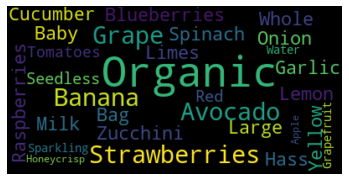

In [ ]:
reorder_products = reorder_products.toPandas()
wordcloud = WordCloud(max_font_size=50).generate(' '.join(reorder_products.product_name))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# Organize and View Shopping Basket

In [ ]:
raw_data = order_products_train.join(products, on='product_id')
baskets = raw_data.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.show(20, False)

+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|order_id|items                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)
model = fpGrowth.fit(baskets)

# Most Frequent Itemsets

In [ ]:
# Display frequent itemsets.
freq_itemsets = model.freqItemsets
freq_itemsets = freq_itemsets.filter(size(freq_itemsets.items) > 2).orderBy('freq', ascending= False).show(20, False)

+--------------------------------------------------------------------+----+
|items                                                               |freq|
+--------------------------------------------------------------------+----+
|[Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas]|710 |
|[Organic Raspberries, Organic Strawberries, Bag of Organic Bananas] |649 |
|[Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas]|587 |
|[Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas] |531 |
|[Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas]|497 |
|[Organic Avocado, Organic Baby Spinach, Banana]                     |484 |
|[Organic Avocado, Large Lemon, Banana]                              |477 |
|[Limes, Large Lemon, Banana]                                        |452 |
|[Organic Cucumber, Organic Strawberries, Bag of Organic Bananas]    |424 |
|[Limes, Organic Avocado, Large Lemon]                               |389 |
|[Organic Ra

In [ ]:
# Display generated association rules.
associationRules = model.associationRules
associationRules = (associationRules.withColumnRenamed('antecedent', 'antecedent(if)')
                                   .withColumnRenamed('consequent', 'consequent(then)')).orderBy('confidence', ascending=False)
associationRules.show(20, False)

+------------------------------------------------------------------+------------------------+-------------------+------------------+
|antecedent(if)                                                    |consequent(then)        |confidence         |lift              |
+------------------------------------------------------------------+------------------------+-------------------+------------------+
|[Organic Raspberries, Organic Hass Avocado, Organic Strawberries] |[Bag of Organic Bananas]|0.5984251968503937 |5.072272070642333 |
|[Organic Cucumber, Organic Hass Avocado, Organic Strawberries]    |[Bag of Organic Bananas]|0.546875           |4.635330870478036 |
|[Organic Kiwi, Organic Hass Avocado]                              |[Bag of Organic Bananas]|0.5459770114942529 |4.627719489738336 |
|[Organic Navel Orange, Organic Raspberries]                       |[Bag of Organic Bananas]|0.5412186379928315 |4.587387356098284 |
|[Yellow Onions, Strawberries]                                     |[